# Training a Convolutional Neural Network to Classify Chest X-rays

## Introduction

This notebook shows how to train a state of the art Convolutional Neural Network
(CNN) to classify chest X-rays images from the MIMIC CXR Dataset. Its approach
is influenced by [CheXpert: A Large Chest Radiograph Dataset with Uncertainty
Labels and Expert Comparison](https://arxiv.org/abs/1901.07031).

You can run this notebook from [Colab](https://colab.research.google.com/) or
[Cloud AI Platform Notebook](https://cloud.google.com/ai-platform-notebooks/).
If you're serious about training your own models, you'll definitely want to use
a Cloud AI Platform notebook with one or more TPUs or GPUs. If you're just
interested in learning how to train a CNN, you can run this notebook in Colab.
Your Colab session will probably timeout before it can finish training the model
(Cloud AI Platform notebooks are more powerful and never timeout). In any case,
don't worry, several pretrained models are available along with the data.

In [0]:
from __future__ import division
from __future__ import print_function

import datetime
import os
import tensorflow as tf
import multiprocessing
from enum import Enum
from google.cloud import bigquery
import seaborn as sns
import matplotlib.pyplot as plt
import sklearn.metrics
import numpy as np
import subprocess
import re

try:
  from google.colab import auth
  IN_COLAB = True
  auth.authenticate_user()
except ImportError:
  IN_COLAB = False

account = subprocess.check_output(
    ['gcloud', 'config', 'list', 'account', '--format',
     'value(core.account)']).decode().strip()
MY_DIRECTORY = re.sub(r'[^\w]', '_', account)[:128]

%config InlineBackend.figure_format = 'svg'

## Understanding the dataset

First, we need to specify where the training and validation datasets are
located. Labelled images are provided in
[TFRecord](https://www.tensorflow.org/guide/datasets#consuming_tfrecord_data)
format. TFRecords are a great choice for performant and convenient training. You
also have access to BigQuery tables that contain the labels for each image,
which we'll use to get a broad understanding of how the labels are distributed
before we dive into training our model.

There are separate TFRecords for X-rays taken from frontal or lateral views. You
can choose either type of dataset, but make sure the validation and training
dataset correspond to the same view. There are pretrained models available for
both views.

In [0]:
#@title Input Datasets {run: "auto"}
GCP_ANALYSIS_PROJECT = 'aarhus-critical-2019-team'  #@param {type: "string"}
TRAIN_TFRECORDS = 'gs://mimic_cxr_derived/tfrecords/train/frontal*'  #@param {type: "string"}
VALID_TFRECORDS = 'gs://mimic_cxr_derived/tfrecords/valid/frontal*'  #@param {type: "string"}
# VIEW should be one of 'frontal', or 'lateral'
VIEW = 'frontal'  #@param ["frontal", "lateral"] {type: "string"}
TRAIN_BIGQUERY = 'physionet-data.mimic_cxr_derived.labels_train'  #@param {type: "string"}
VALID_BIGQUERY = 'physionet-data.mimic_cxr_derived.labels_valid'  #@param {type: "string"}

The dataset consists of labelled images. These labels were determined by
analyzing radiologist notes. A label is given the value of

*   `0` (`not_mentioned`) if the note made no mention of it
*   `1` (`negative`) if the note said the label wasn't present in the image
*   `2` (`uncertain`) if the note expressed uncertainty about the label's
    presence
*   `3` (`positive`) if the label was mentioned with certainty in the note

for more details about how these labels were generated, you can check out
[this paper](https://arxiv.org/abs/1901.07031). For our classifier we'll treat
`not_mentioned` (`0`) and `negative` (`1`) as the same thing. There's some
choice in how we handle `uncertain` (`2`). We will investigate the uncertain labels in the next section.

In [0]:
class Labels(Enum):
  no_finding = 0
  enlarged_cardiomediastinum = 1
  cardiomegaly = 2
  airspace_opacity = 3
  lung_lesion = 4
  edema = 5
  consolidation = 6
  pneumonia = 7
  atelectasis = 8
  pneumothorax = 9
  pleural_effusion = 10
  pleural_other = 11
  fracture = 12
  support_devices = 13


class LabelValues(Enum):
  not_mentioned = 0
  negative = 1
  uncertain = 2
  positive = 3


class Views(Enum):
  frontal = 0
  lateral = 1
  other = 2


class Datasets(Enum):
  train = 0
  valid = 1

Before we start building our model, let's check out the distribution of the
data. We'll do this by writing a BigQuery StandardSQL statement that counts the
number of `not_mentioned`, `negative`, `uncertain` and `positive` values for
each label.

In [25]:
bq_client = bigquery.Client(project=GCP_ANALYSIS_PROJECT)

queries = []
for label in Labels:
  queries.append("""
    SELECT
      "{label}" AS label,
      {label} AS label_value,
      COUNT(DISTINCT path) AS cnt,
      dataset
    FROM
      (SELECT * FROM `{TRAIN_BIGQUERY}`
      UNION ALL
      SELECT * FROM `{VALID_BIGQUERY}`)
    WHERE view = {view_value}
    GROUP BY {label}, dataset
    """.format(
        TRAIN_BIGQUERY=TRAIN_BIGQUERY,
        VALID_BIGQUERY=VALID_BIGQUERY,
        label=label.name,
        view_value=Views[VIEW].value))

barplot_df = bq_client.query('UNION ALL'.join(queries)).to_dataframe()
# Convert integer label values into strings
barplot_df.label_value = barplot_df.label_value.apply(
    lambda v: LabelValues(v).name)
barplot_df.dataset = barplot_df.dataset.apply(lambda v: Datasets(v).name)
print('Query succeeded!')

W0820 06:34:16.870702 140048979654528 _default.py:280] No project ID could be determined. Consider running `gcloud config set project` or setting the GOOGLE_CLOUD_PROJECT environment variable


Query succeeded!


Our StandardSQL statement returns a pandas Dataframe in 'long' format, which
makes it really easy to visualize with [seaborn](https://seaborn.pydata.org/)
(or [ggplot2](https://ggplot2.tidyverse.org/) for R users).

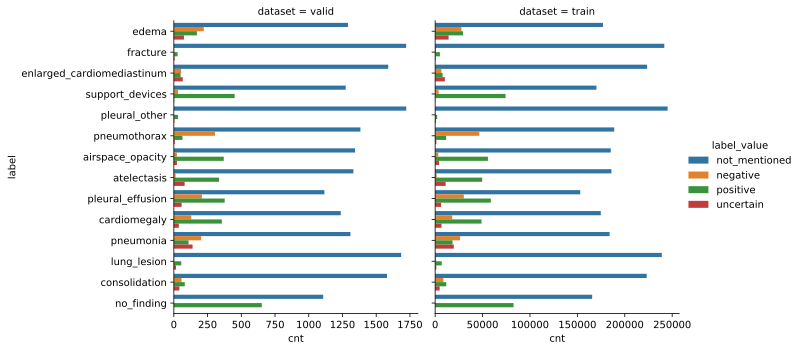

In [26]:
sns.catplot(
    y='label',
    x='cnt',
    hue='label_value',
    data=barplot_df,
    col='dataset',
    kind='bar',
    sharex=False)

In [27]:
N_TRAIN = barplot_df.cnt[(barplot_df.dataset == 'train')
                         & (barplot_df.label == Labels(0).name)].sum()
N_VALID = barplot_df.cnt[(barplot_df.dataset == 'valid')
                         & (barplot_df.label == Labels(0).name)].sum()
print('training examples: {:,}\nvalidation examples: {:,}'.format(
    N_TRAIN, N_VALID))

training examples: 248,285
validation examples: 1,759


What have we learned from this?

*   we have a medium sized dataset for training a CNN. For comparison
    [ImageNet](http://www.image-net.org/) has 14 million images, and
    [CIFAR-10](https://www.cs.toronto.edu/~kriz/cifar.html) has 60,000 images.
*   the distribution of the values varies for each label, the only constant is
    that the majority of values are `not_mentioned`.

This informs our expectations for any model's performance with each label. It
also suggests that we find a way to take advantage of the `uncertain` labels,
since in some cases they actually outnumber the `positive` labels.

## Creating an input pipeline

### Performance considerations

One of the most important factors in determining how long it takes to train a
model is the process that loads data into the model. TPUs and GPUs are so fast
that keeping them busy with the next batch of data isn't easy.

A few tips for fast input pipelines:

1.  Use TFRecords: they allow for data to be read in contiguous blocks, which is
    much faster than reading a bunch of small files.
1.  Train your models and store your data in the cloud so you can take advantage
    of Google's fast internal networks.
1.  Perform expensive transformations, including resizing large images, ahead of
    time. We've already done this for you using
    [Cloud Dataflow](https://cloud.google.com/dataflow/).
1.  Use the largest batch size that will fit in your device's memory.

You can find more tips
[here](https://www.tensorflow.org/alpha/guide/data_performance). And if you're
using a cloud TPU, you can also use the
[`cloud_tpu_profiler`](https://cloud.google.com/tpu/docs/cloud-tpu-tools#profile_tab),
which is an incredibly helpful tool for improving your model's performance.

### Dealing with uncertain labels (advanced)

Our second issue is how to assign values to the uncertain labels. This is a
little technical, so feel free to skim through this section.

Almost all multi-label neural networks use a loss function like this:

$$
L = - \sum_{n,i} l\left(y_{ni}, t_{ni}\right)
$$

Where $t_{ni}$ is the true value of the $i^\text{th}$ label of the $n^\text{th}$
sample and $y_{ni}$ is the corresponding prediction from our model.

One way to incorporate uncertain labels is to assign them a value $u \in [0, 1]$
and a weight $w \in [0, 1]$ to that our loss function becomes

$$
L =  - \sum_{n,i} \begin{cases}
l\left(y_{ni}, t_{ni}\right) & (n, i)^{\text{th}} \text{ label is certain} \\
w \cdot l\left(y_{ni}, u\right) & (n, i)^{\text{th}} \text{ label is uncertain}
\end{cases}
$$

$w = 0$ corresponds to ignoring the uncertain labels. $w = 1, u = 0$ corresponds
to counting all uncertain labels as negative. $w = 1, u = 1$ counts the
uncertain labels as positive. Something like $w = 0.5, u = 0.25$ is a hybrid of
the others. You can think of $w$ as playing the role of $\sigma^2$ if $l$ was
the log-likelihood of a normal distribution.

Other approaches for incorporating uncertain labels into a model are discussed
[here](https://arxiv.org/abs/1901.07031). You could also experiment with using
different values of $u$ and $w$ for each label. You could even try to optimize
these hyperparameters. The per label values of $u$ for example could be learned
with gradient descent, while $w$ could be updated every epoch to optimize the
loss on the `certain` labels.

In summary:

*   `U_VALUE` ($u$) is the probability of being `positive` that you assign to
    uncertain labels
*   `W_VALUE` ($w$) is the weight that you assign to uncertain labels during
    training.

In [0]:
#@title Input pipeline parameters {run: "auto"}
BATCH_SIZE = 32  #@param {type: "integer"}
NUM_EPOCHS = 3  #@param {type: "integer"}
U_VALUE = 0.4  #@param {type:"slider", min:0, max:1, step:0.01}
W_VALUE = 0.75  #@param {type:"slider", min:0, max:1, step:0.01}

In [0]:
# label -> probability table: 0 -> 0, 1 -> 0, 2 -> u, 3 -> 1
probabs_lookup = tf.constant([0.0, 0.0, U_VALUE, 1.0])
# label -> weight table: 0 -> 1, 1 -> 1, 2 -> w, 3 -> 1
weights_lookup = tf.constant([1.0, 1.0, W_VALUE, 1.0])

In [0]:
feature_description = {'jpg_bytes': tf.io.FixedLenFeature([], tf.string)}
for l in Labels:
  feature_description[l.name] = tf.io.FixedLenFeature([], tf.int64)

# The height, width, and number of channels of the input images
INPUT_HWC = (320, 320, 1)


def parse_function(example):
  """Convert a TFExample from a TFRecord into an input and its true label.

    Args:
      example (tf.train.Example): A training example read from a TFRecord.

    Returns:
      Tuple[tf.Tensor, tf.Tensor]: The X-ray image and its labels. The labels
        are represented as two stacked arrays. One array is the probability
        that this label exists in the image, the other is how much weight this
        label should have when training the model.
    """
  parsed = tf.io.parse_single_example(example, feature_description)
  # Turn the JPEG data into a matrix of pixel intensities
  image = tf.io.decode_jpeg(parsed['jpg_bytes'], channels=1)
  # Give the image a definite size, which is needed by TPUs
  image = tf.reshape(image, INPUT_HWC)
  # Normalize the pixel values to be between 0 and 1
  scaled_image = (1.0 / 255.0) * tf.cast(image, tf.float32)
  # Combine the labels into an array
  labels = tf.stack([parsed[l.name] for l in Labels], axis=0)
  # Convert the labels into probabilities and weights using lookup tables.
  probs = tf.gather(probabs_lookup, labels)
  weights = tf.gather(weights_lookup, labels)
  # Return the input to the model and the true labels
  return scaled_image, tf.stack([probs, weights], axis=0)


def get_dataset(valid=False):
  """Construct a pipeline for loading the data.

    Args:
      valid (bool): If this is True, use the validation dataset instead of the
        training dataset.

    Returns:
      tf.data.Dataset: A dataset loading pipeline ready for training.
    """
  n_cpu = multiprocessing.cpu_count()
  tf_records = VALID_TFRECORDS if valid else TRAIN_TFRECORDS
  dataset = tf.data.TFRecordDataset(
      tf.io.gfile.glob(tf_records),
      buffer_size=16 * 1024 * 1024,
      num_parallel_reads=n_cpu)
  if not valid:
    dataset = dataset.shuffle(256)
  dataset = dataset.repeat()
  dataset = dataset.map(parse_function, num_parallel_calls=n_cpu)
  dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
  dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
  return dataset

## Using accelerators (TPUs and GPUs)

One of the most exciting things about training neural networks on the cloud is
the ability to scale your compute power. Tensorflow makes it easy to scale from
a single GPU to a multi-GPU system, to a network of distributed GPU systems.
TPUs are even easier. Since all TPUs are distributed systems (with 8 cores and 4
chips per board), you can scale from a single TPU to a TPU pod without changing
any of your code.

In [0]:
#@title Accelerators {run: "auto"}
ACCELERATOR_TYPE = 'Single-GPU'  #@param ["Single/Multi-TPU", "Single-GPU", "Multi-GPU", "CPU"] {type: "string"}

In [0]:
if ACCELERATOR_TYPE == 'Single/Multi-TPU':
  if IN_COLAB:
    tpu_name = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  else:
    tpu_name = os.environ['TPU_NAME']
  resolver = tf.contrib.cluster_resolver.TPUClusterResolver(tpu=tpu_name)
  tf.contrib.distribute.initialize_tpu_system(resolver)
  strategy = tf.contrib.distribute.TPUStrategy(resolver, steps_per_run=100)
elif ACCELERATOR_TYPE == 'Multi-GPU':
  strategy = tf.distribute.MirroredStrategy()
else:
  strategy = tf.distribute.get_strategy()  # Default strategy

## Defining the model

The [keras applications module](https://keras.io/applications/) offers several
different CNN architectures for us to choose from, all of which are very good.

All we have to do is add the last layer which produces a value for each of our
labels. Notice that the activation function for this layer is `'linear'`. That's
because our loss function applies its own `sigmoid` nonlinearity to `y_pred`.

We define a custom loss function, that unpacks the true probabilities and
assigned weights from our input pipeline before using these to compute a
weighted cross-entropy loss.

In [33]:
with strategy.scope():
  base_model = tf.keras.applications.densenet.DenseNet121(
      include_top=False, weights=None, input_shape=INPUT_HWC, pooling='max')

  predictions = tf.keras.layers.Dense(
      len(Labels), activation='linear')(
          base_model.output)

  model = tf.keras.Model(inputs=base_model.input, outputs=predictions)

  def weighted_binary_crossentropy(prob_weight_y_true, y_pred):
    """Binary cross-entropy loss function with per-sample weights."""
    prob_weight_y_true = tf.reshape(prob_weight_y_true, (-1, 2, len(Labels)))
    # Unpack the second output of our data pipeline into true probabilities and
    # weights for each label.
    probs = prob_weight_y_true[:, 0]
    weights = prob_weight_y_true[:, 1]
    return tf.compat.v1.losses.sigmoid_cross_entropy(
        probs,
        y_pred,
        weights,
        reduction=tf.compat.v1.losses.Reduction.SUM_OVER_BATCH_SIZE)

  model.compile(
      optimizer=tf.train.AdamOptimizer(),
      loss=weighted_binary_crossentropy,
  )

W0820 06:34:19.144250 140048979654528 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0820 06:34:27.072368 140048979654528 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


## Training the model

You can keep track of your loss function and weights during training by saving
the training log files to Google Cloud Storage and running a
[TensorBoard](https://www.tensorflow.org/guide/summaries_and_tensorboard)
session in a Google Cloud Shell or on your local machine.

In [0]:
#@title GCS Tensorboard log directory {run: "auto"}
GCS_LOGS = 'gs://aarhus-critical-2019-team-shared-files/train_log'  #@param {"type": "string"}
if not GCS_LOGS.endswith('/'):
  GCS_LOGS += '/'
GCS_LOGS += MY_DIRECTORY + '/'

Training your model will take hours. You don't have time to waste, so feel free
to stop training at any time. You can do this by interrupting the execution of
the below cell, either by pressing `⌘/Ctrl+m i` on your keyboard or by clicking
the stop sign in the upper left corner with your mouse.

We've already trained and generated predictions for several models that you can
use throughout the datathon. We'll show you how to use them in the next
sections.

In [35]:
now_str = datetime.datetime.now().strftime('%Y%m%d-%H%M%S')
callbacks = []
if GCS_LOGS:
  LOGDIR = GCS_LOGS + ('' if GCS_LOGS.endswith('/') else '/') + now_str
  callbacks.append(tf.keras.callbacks.TensorBoard(LOGDIR, update_freq=500))
  print('Run `tensorboard --logdir {}` in cloud shell or your local machine.'
        .format(GCS_LOGS))

model.fit(
    get_dataset(),
    epochs=NUM_EPOCHS,
    steps_per_epoch=N_TRAIN // BATCH_SIZE,
    validation_data=get_dataset(valid=True),
    validation_steps=N_VALID // BATCH_SIZE,
    callbacks=callbacks)

Run `tensorboard --logdir gs://aarhus-critical-2019-team-shared-files/train_log/johannes_ne_gmail_com/` in cloud shell or your local machine.
Epoch 1/3
   1/7758 [..............................] - ETA: 47:57:56 - loss: 2.3383

W0820 06:35:55.619865 140048979654528 callbacks.py:257] Method (on_train_batch_end) is slow compared to the batch update (2.980294). Check your callbacks.


 660/7758 [=>............................] - ETA: 1:41:01 - loss: 0.3476

KeyboardInterrupt: ignored

## Saving the model

Let's save our model and copy it to Google Cloud Storage.

First we'll give our model a descriptive name and decide where to put it.

In [0]:
#@title Saved model files {run: "auto"}
MODEL_NAME = 'my_model.h5'  #@param {type: "string"}
GCS_SAVED_MODEL_DIR = 'gs://aarhus-critical-2019-team-shared-files/mimic-cxr-models/'  #@param {type: "string"}
GCS_MODEL_PATH = GCS_SAVED_MODEL_DIR
if not GCS_MODEL_PATH.endswith('/'):
  GCS_MODEL_PATH += '/'
GCS_MODEL_PATH += MY_DIRECTORY + '/'
GCS_MODEL_PATH += MODEL_NAME

Since `tf.data` and `tf.io.gfile` treat files stored in Google Cloud Storage the
same as if they were on your local hard drive, uploading and downloading to GCS
is the same as reading and writing from your disk in python.

In [0]:
def upload_to_gcs(local_path, gcs_path):
  with tf.io.gfile.GFile(gcs_path, 'wb') as gcs_file:
    with tf.io.gfile.GFile(local_path, 'rb') as local_file:
      gcs_file.write(local_file.read())


def download_from_gcs(gcs_path, local_path):
  with tf.io.gfile.GFile(gcs_path, 'rb') as gcs_file:
    with tf.io.gfile.GFile(local_path, 'wb') as local_file:
      local_file.write(gcs_file.read())

`model.save` save the entire model, including its architecture, learned weights,
optimizer, and loss function.

In [0]:
model.save(MODEL_NAME)
upload_to_gcs(MODEL_NAME, GCS_MODEL_PATH)

## Making and evaluating predictions

We've used this notebook to pretrain eight different models for you
to experiment with.

We trained these models on two different image views and four different
imputation strategies.

*   View:
    *   frontal
    *   lateral
*   Strategy for uncertain labels, $u$, $w$:
    *   Ignore uncertain labels, $u = 0$, $w = 0$
    *   Assign uncertain labels to negative, $u = 0$, $w = 1$
    *   Assign uncertain labels to positive, $u = 1$, $w = 1$
    *   Hybrid, $u = 0.5$, $w = 0.25$

These pretrained keras models are hosted in Google Cloud Storage, and are
available for you to use throughout the datathon.

The predictions given by each model are also available in BigQuery. We suggest
using these if your team is interested in combining multiple viewpoints or
building an ensemble model.

First, choose the location of your pretrained keras model on GCS and its table
of predictions in BigQuery.

In [0]:
PRETRAINED_KERAS_MODEL = 'gs://mimic_cxr_derived/models/densenet_frontal_u0_0__w0_0.h5'  #@param {type: "string"}
VALID_PREDICTIONS_BIGQUERY = 'physionet-data.mimic_cxr_derived.densenet_frontal_u0_0__w0_0_predictions'  #@param {type: "string"}

Then we'll download and load the keras model.

In [40]:
# Download the model from GCS
download_from_gcs(PRETRAINED_KERAS_MODEL, 'pretrained_model.h5')

# Load the model, strategy.scope allows us to exploit multiple accelerators,
# just like we did during training.
with strategy.scope():
  model = tf.keras.models.load_model('pretrained_model.h5', compile=False)
  model.compile(
      optimizer=tf.train.AdamOptimizer(), loss=weighted_binary_crossentropy)

W0820 07:24:21.216652 140048979654528 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling GlorotUniform.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0820 07:24:21.218059 140048979654528 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Zeros.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0820 07:24:21.220386 140048979654528 deprecation.py:506] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/init_ops.py:97: calling Ones.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecat

We can make predictions with this Keras model by calling
[`.predict()`](https://www.tensorflow.org/api_docs/python/tf/keras/models/Model#predict).
`.predict()` accepts several different input data types including
`tf.data.Dataset`, `np.array`, and more.

In [41]:
example_predictions = model.predict(get_dataset(valid=False), steps=3)
print('shape: {}, min: {}, max: {}'.format(example_predictions.shape,
                                           example_predictions.min(),
                                           example_predictions.max()))

shape: (96, 14), min: -9.002674102783203, max: 2.6530423164367676


To compare the model's accuracy against the true labels, let's write a SQL query
to join the predicted and true labels.

In [0]:
pred_true_df = bq_client.query("""SELECT * FROM
(SELECT {0} FROM `{1}` WHERE dataset = {4})
INNER JOIN
(SELECT {2} FROM `{3}` WHERE dataset = {4})
USING (path)
""".format(
    'path, ' + ', '.join('{0} AS predicted_{0}'.format(l.name) for l in Labels),
    VALID_PREDICTIONS_BIGQUERY,
    'path, ' + ', '.join('{0} AS true_{0}'.format(l.name) for l in Labels),
    VALID_BIGQUERY, Datasets.valid.value)).to_dataframe()

With this dataframe, we can plot the precision-recall and ROC curves for each
label.

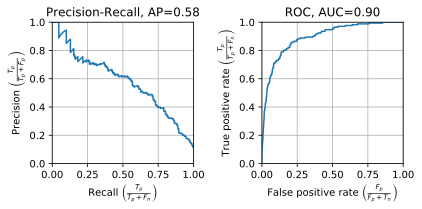

In [43]:
#@title Evaluation {run: "auto"}
label = 'edema'  #@param ['no_finding', 'enlarged_cardiomediastinum', 'cardiomegaly', 'airspace_opacity', 'lung_lesion', 'edema', 'consolidation', 'pneumonia', 'atelectasis', 'pneumothorax', 'pleural_effusion', 'pleural_other', 'fracture', 'support_devices'] {type:"string"}

predicted = pred_true_df['predicted_{}'.format(label)]
true = pred_true_df['true_{}'.format(label)]

# Ignore uncertain labels for calculating metrics
certain_mask = (true != LabelValues.uncertain.value)
true = true[certain_mask]
predicted = predicted[certain_mask]
# Use the same encodings as during training:
# not_mentioned, negative -> 0
# positive -> 1
true = np.array([float(LabelValues.positive == v) for v in LabelValues])[true]

fig, axes = plt.subplots(1, 2)

# Plot the precision-recall curve
precision, recall, thresholds = sklearn.metrics.precision_recall_curve(
    true, predicted)
average_precision = sklearn.metrics.average_precision_score(true, predicted)

pr_axis = axes[0]
pr_axis.plot(recall, precision)
pr_axis.set_aspect('equal')
pr_axis.set_xlim(0, 1)
pr_axis.set_ylim(0, 1)
pr_axis.set_xlabel(r'Recall $\left(\frac{T_p}{T_p + F_n} \right)$')
pr_axis.set_ylabel(r'Precision $\left(\frac{T_p}{T_p + F_p} \right)$')
pr_axis.set_title('Precision-Recall, AP={:.2f}'.format(average_precision))
pr_axis.grid(True)

# Plot the ROC curve
fpr, tpr, thresholds = sklearn.metrics.roc_curve(true, predicted)
roc_auc = sklearn.metrics.roc_auc_score(true, predicted)

roc_axis = axes[1]
roc_axis.plot(fpr, tpr)
roc_axis.set_aspect('equal')
roc_axis.set_xlim(0, 1)
roc_axis.set_ylim(0, 1)
roc_axis.set_xlabel(
    r'False positive rate $\left(\frac{F_p}{F_p + T_n} \right)$')
roc_axis.set_ylabel(r'True positive rate $\left(\frac{T_p}{T_p + F_n} \right)$')
roc_axis.set_title('ROC, AUC={:.2f}'.format(roc_auc))
roc_axis.grid(True)

plt.tight_layout()

## Project Ideas

Ready to go off and explore MIMIC CXR on your own? Here are some ideas for
projects your team could work on.

1.  Multiple models are provided as pretrained models. How will your team choose
    the best one? Could you combine them into an ensemble method?
1.  The pretrained models handle "uncertain" labels differently. How does this
    choice impact the model's predictions? Are the results what you would
    expect? Can we use these results to learn something about how each of the
    different labels were generated?
1.  Most imaging studies have multiple frontal and lateral images. How can you
    combine the predictions from each image into a prediction for each study?
    Would a logistic-linear model work? What about using the maximum prediction
    in each category?
1.  Investigate the images that are taken from a view other than frontal or
    lateral. What do these images look like? Could you design and/or train a
    model that uses these images?

## Conclusion

That's it! You've trained a Convolutional Neural Network to classify chest X-ray
images.

We've just scratched the surface of machine learning on GCP. The
[Cloud AI Platform](https://cloud.google.com/ai-platform/) has a full suite of
tools for research to production ML development including preprocessing
pipelines, Jupyter notebooks, distributed training, and model serving.